# 02. Tensorflow Intro

A few simple examples of using tensorflow

#### Some Tensorflow Wisdom

* You should never use loops(!). It adds tons of redundant tensors to your graph. Use only array operations
* Use `tf.where()` for booleans
* Use `gather`/`scatter` for slicing tensors with indices computed at runtime
* TF can only check types/shape when building graph. Must wait until session to see errors like divide by 0
* Use variable `assign` or `assign_add` to add things while computing
* Use `tf.histogram_fixed_width` for histogramming or going from values to counts
* TF infers which tensors must be computed based on what you ask for in `sess.run(...)`. Use `tf.control_dependency` to force things to be computed
* For complex multiply/adds (like batched dot products of list of particles), use the general `tf.einsum` function
* `tf.shape(x)` gets the runtime shape of a tensor. `x.shape` gets the shape of a tensor while building the graph.
* A shape value of `-1` (e.g., [-1, 5]) means infer the value, which can be possible in a reshape. `None` (e.g., [None, 5]) means that the shape value will only be known at run time. 
* Use `tf.tile` to repeat quantities
* You can check correctness with things like `tf.is_finite`
* You can assess numerical errors using the `tf.debugging.check_numerics(x)` op which will halt tf is a tensor becomes nan
* Each python expression is an op, which must be called to be evaluated, unless its result is used later

In [1]:
import tensorflow as tf
import numpy as np
import numpy.random as nprand
import matplotlib.pyplot as plt

## Basic Computations

In [2]:
# Compute product of two numbers
a = tf.constant(2.) # a constant tensor
b = tf.constant(5.)
c = a * b # a tensor which is computed
with tf.Session() as sess:
    result = sess.run(c)
print(result)

10.0


## Feeding into placeholders

In [3]:
# RESET GRAPH!
tf.reset_default_graph()

matrix = tf.placeholder(tf.float64, shape=[4, 2])
c = tf.reduce_sum(matrix, axis=1)
matrix_values = np.arange(4 * 2).reshape(4,2)

with tf.Session() as sess:
    result = sess.run(c, feed_dict={matrix: matrix_values})
print('Input:\n', matrix_values)
print('Output:', result)

Input:
 [[0 1]
 [2 3]
 [4 5]
 [6 7]]
Output: [ 1.  5.  9. 13.]


## Linear Regression

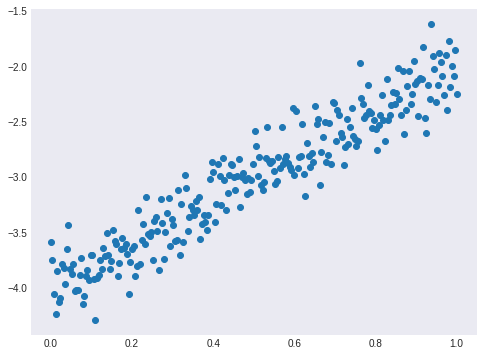

In [4]:
N = 256
x_values = np.linspace(0,1,N)
# shuffle data
nprand.shuffle(x_values)
m_true = 2
b_true = -4
y_values = x_values * m_true + b_true + nprand.normal(size=x_values.shape, scale=0.2)


plt.style.use('seaborn-dark')
plt.figure(figsize=(8,6))
plt.plot(x_values, y_values, 'o')
plt.show()

In [5]:
tf.reset_default_graph()
# set-up loss
x = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32)
m = tf.get_variable('m',initializer=1.0)
b = tf.get_variable('b', initializer=0.0)
yhat = x * m + b
loss = tf.reduce_sum((yhat - y)**2, axis=0)
optimizer = tf.train.GradientDescentOptimizer(1e-1).minimize(loss)

# learn by minibatching data
batch_size = 4
with tf.Session() as sess:
    # must initialize the variables
    sess.run(tf.global_variables_initializer())
    for i in range(0,len(x_values), batch_size):
        result = sess.run([m, b, loss, optimizer], feed_dict={x: x_values[i:(i+batch_size)], y:y_values[i:(i+batch_size)]})
print('final result', result)

W0308 23:26:41.222957 139810421933888 deprecation.py:323] From /home/whitead/miniconda3/envs/htf/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


final result [1.9365615, -3.9615045, 0.20088643, None]


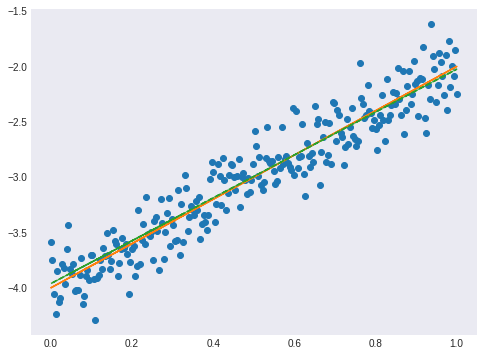

In [6]:
plt.style.use('seaborn-dark')
plt.figure(figsize=(8,6))
plt.plot(x_values, y_values, 'o')
plt.plot(x_values, x_values * m_true + b_true, '-')
plt.plot(x_values, x_values * result[0] + result[1], '--')
plt.show()


## Neural Network

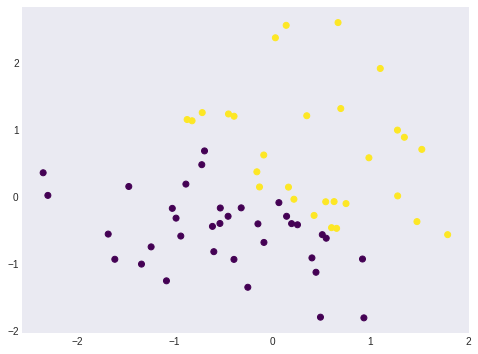

In [7]:
N = 64
feature_values = nprand.normal(size=[N, 2], scale=1)
label_values = np.sum(feature_values * np.ones((N,2)), axis=1) > 0
onehot_labels = np.vstack((label_values, ~label_values)).astype(np.float32).T

plt.style.use('seaborn-dark')
plt.figure(figsize=(8,6))
plt.scatter(feature_values[:,0], feature_values[:,1], c=label_values, cmap='viridis')
plt.show()

W0308 23:26:41.632329 139810421933888 deprecation.py:506] From /home/whitead/miniconda3/envs/htf/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


5.78321171
2.79685211
5.08434534
3.43735576
3.39214087
1.4444387
2.55319977
1.59300661


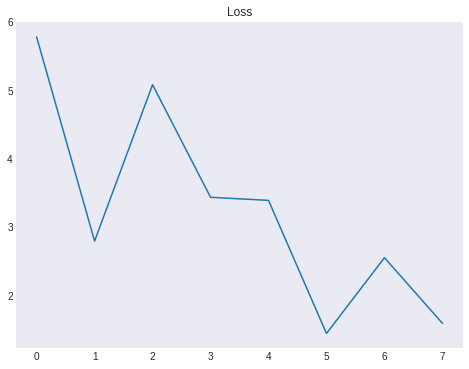

In [8]:
# Create a 2 layer NN

tf.reset_default_graph()
batch_size = 8

# set-up loss
features = tf.placeholder(tf.float32, shape=[None,2])
labels = tf.placeholder(tf.float32)

hidden = tf.keras.layers.Dense(2)(features)
softmax = tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax)(hidden)

loss = tf.reduce_sum(tf.keras.losses.binary_crossentropy(labels, softmax))
# let's print the loss
print_op = tf.print(loss)
optimizer = tf.train.GradientDescentOptimizer(1e-1).minimize(loss)

# learn by minibatching data
losses = []
with tf.Session() as sess:
    # must initialize the variables
    sess.run(tf.global_variables_initializer())
    for i in range(0,N, batch_size):
        result = sess.run([loss, print_op, optimizer], feed_dict={features: feature_values[i:(i+batch_size)], labels:onehot_labels[i:(i+batch_size),:]})
        losses.append(result[0])
    # get final predictions
    label_predicts = sess.run([softmax], feed_dict={features: feature_values})

plt.figure(figsize=(8,6))
plt.plot(losses)
plt.title('Loss')
plt.show()

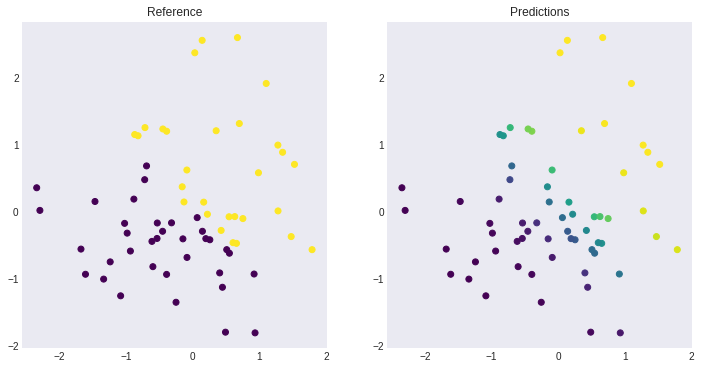

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))
axs[0].set_title('Reference')
axs[0].scatter(feature_values[:,0], feature_values[:,1], c=label_values, cmap='viridis')
axs[1].set_title('Predictions')
axs[1].scatter(feature_values[:,0], feature_values[:,1], c=label_predicts[0][:,0], cmap='viridis')
plt.show()